Import libraries

In [ ]:
import keras, os, random, zipfile, csv
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
#from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import image
from PIL import Image
import torch
from torchvision import transforms

Copy the files from the Drive

In [ ]:
from google.colab import drive
import shutil

drive.mount('/content/drive')
shutil.copy('/content/drive/MyDrive/4 - Pipeline Evaluation Data/AP_LT_Bones.zip', 'AP_LT_Bones.zip')
shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/Trained_Reconstruction_Model.keras', 'Trained_Reconstruction_Model.keras')
shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/Weights.csv', 'Weights.csv')
shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/arial.ttf', 'arial.ttf')
drive.flush_and_unmount()


Mounted at /content/drive


Reading the labels (to calculate the max feature values)

In [ ]:
def read_lines(filepath):
    with open(filepath, 'rU') as data:
        reader = csv.reader(data)
        for row in reader:
            yield [ float(i) for i in row ]

Labels_filepath = 'Weights.csv'
Labels = list(read_lines(Labels_filepath))

labels_num = len(Labels)
feature_size = len(Labels[0])
feature_max_values = np.zeros((feature_size))
for i in range(feature_size):
  max_feature = 0;
  for j in range(labels_num):
    if max_feature < np.abs(Labels[j][i]): # max_feature < np.abs(Labels[j][i+22]):
      max_feature = np.abs(Labels[j][i]) # max_feature = np.abs(Labels[j][i+22]):
  feature_max_values[i] = max_feature

<ipython-input-3-ea60814c09aa>:2: DeprecationWarning: 'U' mode is deprecated
  with open(filepath, 'rU') as data:


First, Upload zip file of the images and then run this Block to unzip the images and read the Weights.

In [ ]:
image_zip_address = '/content/AP_LT_Bones.zip'
images_dir = '/content/AP_LT_Bones/'

with zipfile.ZipFile(image_zip_address, 'r') as zip_ref:
    zip_ref.extractall('/content')

Set the proper settings regarding the Dataset

In [ ]:
image_resolutions = [480, 280]
image_resolutions = [490, 290]
image_resolutions = [890, 460]
image_resolutions = [623, 322] # Used 3*MV, cause the images are large for GPU memory

**Split the Train and Test data randomly (With BG)**

In [ ]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(data, key=alphanum_key)


files = sorted_alphanumeric(os.listdir(images_dir))
# files.sort()
Eval_images = []

for idx, file in enumerate(files):
    my_image = tf.io.read_file(images_dir + file)
    # print(file)
    tensor = tf.io.decode_image(my_image, channels=1, dtype=tf.dtypes.uint8)
    tensor_image = tf.image.resize(tensor, [image_resolutions[0], image_resolutions[1]])
    tensor_image = tf.cast(tensor_image, dtype=tf.uint8)
    # tensor_image = tf.image.rgb_to_grayscale(tensor_image)
    # if len(tensor_image.shape) == 3:
    #    tensor_image = tf.expand_dims(tensor_image, axis=0)
    if (len(tensor_image.shape) > 3):
        print(tensor_image.shape)
        tensor_image = tf.squeeze(tensor_image, axis=0)
        print(tensor_image.shape)
    Eval_images.append(tensor_image)

Eval_images = tf.stack(Eval_images)

Check the size of train and test sets

In [ ]:
print(len(Eval_images))

1000


Plot some images randomly

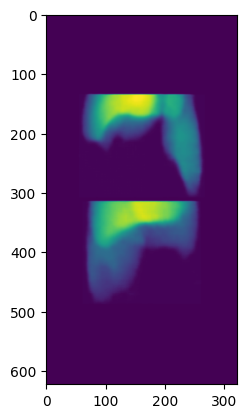

In [ ]:
%matplotlib inline

rand_idx = random.randint(0, len(Eval_images))
im = Eval_images[rand_idx]
plt.imshow(im)

Check images dataset sizes

In [ ]:
print(Eval_images.shape)

(1000, 623, 322, 1)


**Load the model**

In [ ]:
model = tf.keras.models.load_model('Trained_Reconstruction_Model.keras')

In [ ]:
predictions = model.predict(Eval_images)
test_prediction = tf.convert_to_tensor(predictions)

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 273ms/step


In [ ]:
for i in range(len(Labels[0])):
    if i > 22 and i < 26:  # i = 0 .. 21 are MVs, i = 22,23,24 are Rotations, i = 25 is Scale
        print(feature_max_values[i]*180/np.pi)
    else:
        print(feature_max_values[i])
    print("*********************************")

229.925177220786
*********************************
202.79274101935
*********************************
198.117142191412
*********************************
153.114993499837
*********************************
141.390046202305
*********************************
117.976578913931
*********************************
106.806591574616
*********************************
86.469747891241
*********************************
80.2437675672389
*********************************
77.1707516869644
*********************************
74.7821981059851
*********************************
68.5691989404738
*********************************
63.8701743351042
*********************************
59.890017242891
*********************************
55.0079824308745
*********************************
53.1459408502197
*********************************
50.2914982150226
*********************************
47.3094218376007
*********************************
0.08726451583203
*********************************
0.0872602562107069
***************

In [ ]:
result = np.zeros([len(test_prediction), len(test_prediction[0])])
for i in range(len(test_prediction)):
  for j in range(len(test_prediction[i])):
    result[i][j] = test_prediction[i][j].numpy()*feature_max_values[j]
df = pd.DataFrame(result)
df.to_csv('Reconstruction_Result.csv', index=False)

drive.mount('/content/drive')
shutil.copy("Reconstruction_Result.csv", "/content/drive/MyDrive/4 - Pipeline Evaluation Data/Reconstruction_Result.csv")
drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
"""
print('[ ...')
for i in range(len(test_prediction)):
  for j in range(len(test_prediction[i])):
    print(test_prediction[i][j].numpy()*feature_max_values[j], ',', end='')
  print(';...')
print('];')"""

"\nprint('[ ...')\nfor i in range(len(test_prediction)):\n  for j in range(len(test_prediction[i])):\n    print(test_prediction[i][j].numpy()*feature_max_values[j], ',', end='')\n  print(';...')\nprint('];')"

In [ ]:
#from google.colab import runtime
#runtime.unassign()